# Use the Fama-French factor model to measure risk exposure

Eugene Fama and Kenneth French built the Fama-French three-factor model in 1992. It’s a popular factor model you can use for free. The model includes size, style, and excess returns.

The steps are

• Download historic factor data

• Compute the sensitivities to the factors

• Figure out the risk contribution of the factors

In [2]:
# Step 1: Download historic factor data

# First, import the libraries. You can use pandas_datareader to download the factor data and yfinance to download stock price data. Use statsmodels for modeling.

import numpy as np
import pandas as pd

import pandas_datareader as pdr
import yfinance as yf

import statsmodels.api as sm
from statsmodels import regression
from statsmodels.regression.rolling import RollingOLS
# Download the data.

factors = pdr.get_data_famafrench(
    'F-F_Research_Data_Factors',
    start='2000-01-01'
)[0][1:]

SMB = factors.SMB
HML = factors.HML
# SMB is “small minus big” representing the size factor. HML is “high minus low” representing the style factor. This also downloads a third factor, Rm-Rf, which is the market excess return. I only use SMB and HML for this analysis.

# Now get the stock price data for your portfolio. You can pick any stocks you want. (Make sure to include a benchmark like SPY.)

data = yf.download(
    ['SPY', 'MSFT', 'AAPL', 'INTC'],
    start="2000-01-01",
    interval="1mo"
)['Adj Close']

monthly_returns = data.pct_change().to_period("M")
# The factor data is monthly so to align with the stock data, you need to get monthly closing prices and resample to monthly labels. pandas makes it easy.
factors

[*********************100%***********************]  4 of 4 completed


,Mkt-RF,SMB,HML,RF
Date,,,,
2000-02,2.45,21.42,-9.70,0.43
2000-03,5.20,-17.23,8.17,0.47
2000-04,-6.40,-6.68,7.26,0.46
2000-05,-4.42,-6.09,4.81,0.50
2000-06,4.64,12.85,-8.43,0.40
...,...,...,...,...
2022-11,4.60,-3.40,1.38,0.29
2022-12,-6.41,-0.68,1.32,0.33
2023-01,6.65,5.02,-4.05,0.35


In [3]:
# Step 2: Compute the sensitivities to the factors

# Next, compute the active return of the portfolio. The active return is the portfolio return minus the benchmark return.

bench = monthly_returns.pop("SPY")
R = monthly_returns.mean(axis=1)
active = R - bench
# “Pop” the benchmark return off the returns data frame. Then, calculate the portfolio returns and subtract the benchmark.

# Use regression to compute the sensitivities to the factors.

df = pd.DataFrame({
    'R': active,
    'F1': SMB,
    'F2': HML,
}).dropna()

b1, b2 = regression.linear_model.OLS(
    df.R,
    df[['F1', 'F2']]
).fit().params

print(f'Sensitivities of active returns to factors:\nSMB: {b1}\nHML: {b2}')

Sensitivities of active returns to factors:
SMB: 0.0019886356284393907
HML: -0.005955249964094079


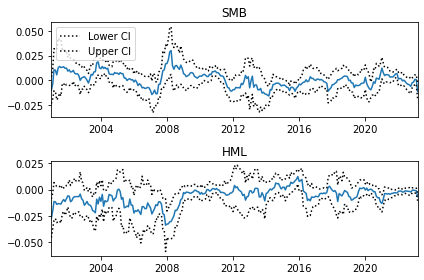

In [4]:
exog_vars = ["SMB", "HML"]
exog = sm.add_constant(factors[exog_vars])
rols = RollingOLS(df.R, exog, window=12)
rres = rols.fit()
fig = rres.plot_recursive_coefficient(variables=exog_vars)

In [5]:
# Step 3: Figure out the risk contribution of the factors

# Marginal Contribution To Active Risk (MCTAR) measures the incremental active risk each additional factor introduces to your portfolio.

F1 = df.F1
F2 = df.F2

cov = np.cov(F1, F2)
ar_squared = (active.std())**2
mcar1 = (b1 * (b2 * cov[0,1] + b1 * cov[0,0])) / ar_squared
mcar2 = (b2 * (b1 * cov[0,1] + b2 * cov[1,1])) / ar_squared
print (f'SMB risk contribution: {mcar1}')
print (f'HML risk contribution: {mcar2}')
print (f'Unexplained risk contribution: {1 - (mcar1 + mcar2)}')

SMB risk contribution: 0.019525974544129583
HML risk contribution: 0.13908199406588484
Unexplained risk contribution: 0.8413920313899856
